# NSC 325 Sweet Spot Identification
Elijah Flores, Aditya Holla, Jayant Bhaskaruni, Beshoy Shaker, and Ameera Aslam

The University of Texas at Austin

In [198]:
# Import statements
!pip install shap
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.model_selection import cross_val_score, KFold
import shap
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
import os
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as st
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor

In [109]:
# Read in file
filename = 'sweetspot_UT_Austin.csv'
df = pd.read_csv(filename)

### Data Exploration and Cleaning

In [110]:
# Size and top 8 rows in dataset
print('Data size:', df.shape)
df.head(n=8)

Data size: (55, 14)


,Well Number,Well Name,Bottomhole X,Bottomhole Y,Co [MSTB],Cw (bbl),POROS,KX,KY,TD(MD),Cg (mmcf),FACIES,P_2020-1-6,P_2029-1-1
0,1,PO1_1,5064.04,13746.23,55.191600,1.617450e-04,0.128029,0.020377,0.020377,8551.7,157.119447,3,3491.971374,2992.403113
1,2,PO1_2,7668.40,13746.23,27.529400,1.394790e-04,0.101876,0.015088,0.015088,8579.9,69.831076,4,3501.327981,2947.374808
2,3,PO1_3,2459.67,13746.23,48.354000,1.973990e-04,0.119220,0.022396,0.022396,8557.1,134.781940,4,3493.763065,2904.053641
3,4,PO1_4,10272.76,13746.23,0.572057,1.440000e-07,0.064132,0.000091,0.000091,8635.5,1.101210,5,3519.775759,3301.826052
4,5,PO1_5,12877.11,13746.23,0.430394,8.560000e-08,0.063078,0.000067,0.000067,8718.6,0.435085,5,3547.347889,3365.597401
5,6,PO1_6,10272.76,11141.88,0.995444,3.840000e-07,0.071007,0.000168,0.000168,8555.5,2.792220,5,3493.232193,3196.746890
6,7,PO1_7,11430.25,11141.88,0.215019,6.030030e-01,0.069382,0.000162,0.000162,8589.1,0.523657,5,3504.380491,3126.405930
7,8,PO1_8,12877.11,11141.88,0.000000,1.244600e+00,0.074247,0.000270,0.000270,8638.6,0.000000,5,3520.804323,2949.434450


In [111]:
# Print out the amount of missing values
print((df == 0).sum())
df[(df == 0).any(axis=1)]

Well Number     0
Well Name       0
Bottomhole X    0
Bottomhole Y    0
Co [MSTB]       5
Cw (bbl)        0
POROS           0
KX              0
KY              0
TD(MD)          0
Cg (mmcf)       5
FACIES          0
P_2020-1-6      0
P_2029-1-1      0
dtype: int64


,Well Number,Well Name,Bottomhole X,Bottomhole Y,Co [MSTB],Cw (bbl),POROS,KX,KY,TD(MD),Cg (mmcf),FACIES,P_2020-1-6,P_2029-1-1
7,8,PO1_8,12877.11,11141.88,0.0,1.24460,0.074247,0.000270,0.000270,8638.6,0.0,5,3520.804323,2949.434450
8,9,PO1_9,14034.61,11141.88,0.0,1.30679,0.073380,0.000284,0.000284,8684.3,0.0,5,3535.967335,2954.485548
26,27,PO1_27,14034.61,8537.52,0.0,30.15660,0.116111,0.033130,0.010039,8645.4,0.0,4,3523.060526,2676.168143
27,28,PO1_28,14034.61,5933.16,0.0,37.77570,0.112872,0.012573,0.012573,8647.7,0.0,4,3523.823653,2694.598799
46,47,PO1_47,14034.61,3328.80,0.0,87.57740,0.143755,0.038000,0.038000,8691.2,0.0,3,3538.256717,2515.127738


In [112]:
# Well number and name are redundant (can use row index) and can be removed.
df.drop(columns=['Well Number', 'Well Name'], inplace=True)
df.head()

,Bottomhole X,Bottomhole Y,Co [MSTB],Cw (bbl),POROS,KX,KY,TD(MD),Cg (mmcf),FACIES,P_2020-1-6,P_2029-1-1
0,5064.04,13746.23,55.191600,1.617450e-04,0.128029,0.020377,0.020377,8551.7,157.119447,3,3491.971374,2992.403113
1,7668.40,13746.23,27.529400,1.394790e-04,0.101876,0.015088,0.015088,8579.9,69.831076,4,3501.327981,2947.374808
2,2459.67,13746.23,48.354000,1.973990e-04,0.119220,0.022396,0.022396,8557.1,134.781940,4,3493.763065,2904.053641
3,10272.76,13746.23,0.572057,1.440000e-07,0.064132,0.000091,0.000091,8635.5,1.101210,5,3519.775759,3301.826052
4,12877.11,13746.23,0.430394,8.560000e-08,0.063078,0.000067,0.000067,8718.6,0.435085,5,3547.347889,3365.597401


In [113]:
# Rename column headers to be more human-readable
mappings = {
    'Bottomhole X': 'bh_x',         # Bottomhole X-coordinate
    'Bottomhole Y': 'bh_y',         # Bottomhole Y-coordinate
    'Co [MSTB]':'oil_prod_mstb',    # Cumulative oil production, thousand stock tank barrels
    'Cw (bbl)':'water_prod_bbl',    # Cumulative water production, barrels
    'POROS':'porosity',             # Porosity
    'KX':'perm_x',                  # X permeability
    'KY':'perm_y',                  # Y permeability
    'TD(MD)':'total_depth_md',      # Total depth (measured depth)
    'Cg (mmcf)':'gas_prod_mmcf',    # Gas production, million cubic feet
    'FACIES':'facies',              # Facies
    'P_2020-1-6':'past_pressure',   # Pressure on January 6, 2020
    'P_2029-1-1':'future_pressure'  # Predicted pressure on January 1, 2029
}

df.rename(columns=mappings, inplace=True)

In [114]:
# One-hot encode facies since it is categorical
df = pd.get_dummies(df, columns=['facies'], drop_first=True)

# Rearrange columns: well coordinates, production amounts, rock info, and dates
df = df[['bh_x', 'bh_y', 'total_depth_md', 'oil_prod_mstb', 'water_prod_bbl', 'gas_prod_mmcf', 'perm_x', 'perm_y', 'porosity', 'facies_2', 'facies_3', 'facies_4', 'facies_5', 'past_pressure', 'future_pressure']]
df.head()

,bh_x,bh_y,total_depth_md,oil_prod_mstb,water_prod_bbl,gas_prod_mmcf,perm_x,perm_y,porosity,facies_2,facies_3,facies_4,facies_5,past_pressure,future_pressure
0,5064.04,13746.23,8551.7,55.191600,1.617450e-04,157.119447,0.020377,0.020377,0.128029,False,True,False,False,3491.971374,2992.403113
1,7668.40,13746.23,8579.9,27.529400,1.394790e-04,69.831076,0.015088,0.015088,0.101876,False,False,True,False,3501.327981,2947.374808
2,2459.67,13746.23,8557.1,48.354000,1.973990e-04,134.781940,0.022396,0.022396,0.119220,False,False,True,False,3493.763065,2904.053641
3,10272.76,13746.23,8635.5,0.572057,1.440000e-07,1.101210,0.000091,0.000091,0.064132,False,False,False,True,3519.775759,3301.826052
4,12877.11,13746.23,8718.6,0.430394,8.560000e-08,0.435085,0.000067,0.000067,0.063078,False,False,False,True,3547.347889,3365.597401


C:\Users\shake\AppData\Local\Temp\ipykernel_37792\1786411911.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df, labels=df.columns)


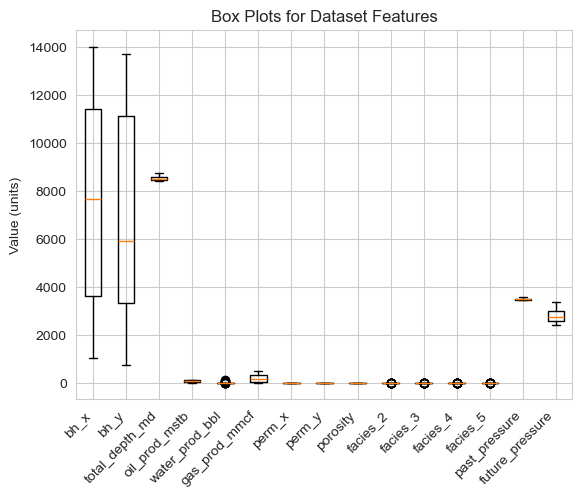

In [115]:
# Boxplots to check for outliers
plt.boxplot(df, labels=df.columns)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Value (units)')
plt.title('Box Plots for Dataset Features')
plt.show()

C:\Users\shake\AppData\Local\Temp\ipykernel_37792\700364222.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df['water_prod_bbl'], labels=['water_prod_bbl'])


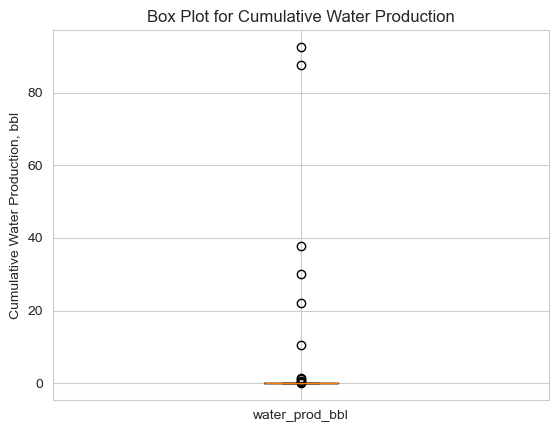

In [116]:
# Water production box plot
plt.boxplot(df['water_prod_bbl'], labels=['water_prod_bbl'])
plt.title('Box Plot for Cumulative Water Production')
plt.ylabel('Cumulative Water Production, bbl')
plt.show()

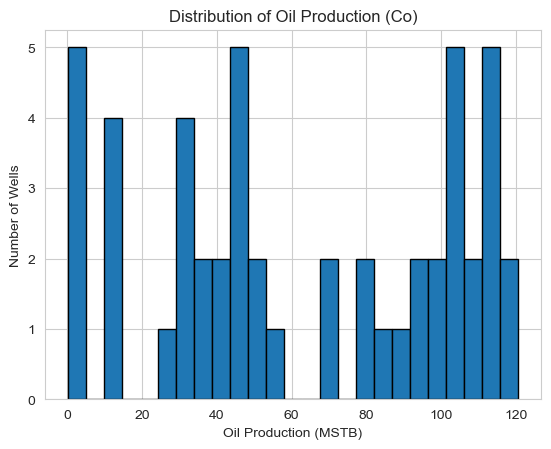

In [117]:
# Treat the 0s as NaN - missing values
temp_df = df['oil_prod_mstb'].replace(0, np.nan).dropna()

# Histogram for oil production
plt.hist(temp_df, bins=25, edgecolor='black')
plt.title('Distribution of Oil Production (Co)')
plt.xlabel('Oil Production (MSTB)')
plt.ylabel('Number of Wells')
plt.show()

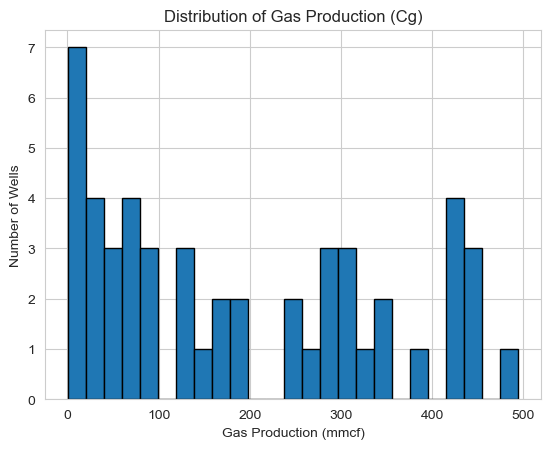

In [118]:
# Treat the 0s as NaN - missing values
temp_df = df['gas_prod_mmcf'].replace(0, np.nan).dropna()

# Histogram for gas production
plt.hist(temp_df, bins=25, edgecolor='black')
plt.title('Distribution of Gas Production (Cg)')
plt.xlabel('Gas Production (mmcf)') 
plt.ylabel('Number of Wells')    
plt.show()

In [119]:
# Missing value imputation

# Replace 0s with NaN 
df['oil_prod_mstb'].replace(0, np.nan, inplace=True)
df['gas_prod_mmcf'].replace(0, np.nan, inplace=True)

# Median imputation (safer than mean due to outliers)
df['oil_prod_mstb'].fillna(df['oil_prod_mstb'].median(), inplace=True)
df['gas_prod_mmcf'].fillna(df['gas_prod_mmcf'].median(), inplace=True)

# Check that there are no more missing values
print(df[['oil_prod_mstb', 'gas_prod_mmcf']].isna().sum())

oil_prod_mstb    0
gas_prod_mmcf    0
dtype: int64


C:\Users\shake\AppData\Local\Temp\ipykernel_37792\4226066532.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['oil_prod_mstb'].replace(0, np.nan, inplace=True)
C:\Users\shake\AppData\Local\Temp\ipykernel_37792\4226066532.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

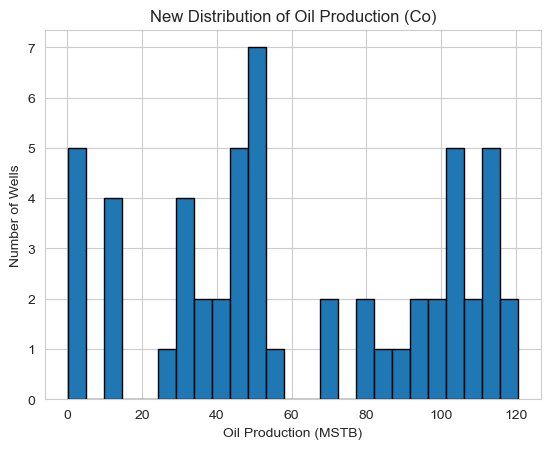

In [120]:
# Histogram for oil production after imputation
plt.hist(df['oil_prod_mstb'], bins=25, edgecolor='black')
plt.title('New Distribution of Oil Production (Co)')
plt.xlabel('Oil Production (MSTB)')
plt.ylabel('Number of Wells')
plt.show()

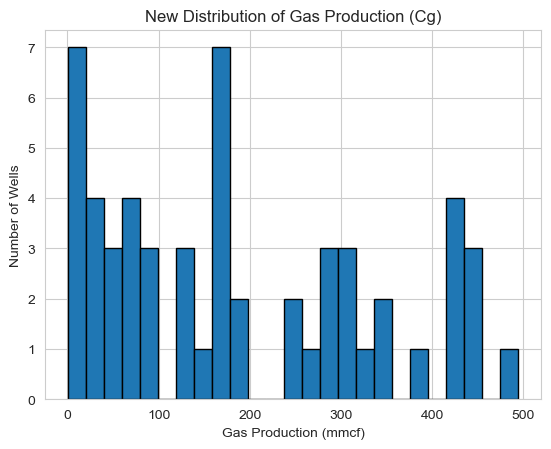

In [121]:
# Histogram for gas production after imputation
plt.hist(df['gas_prod_mmcf'], bins=25, edgecolor='black')
plt.title('New Distribution of Gas Production (Cg)')
plt.xlabel('Gas Production (mmcf)')
plt.ylabel('Number of Wells')
plt.show()

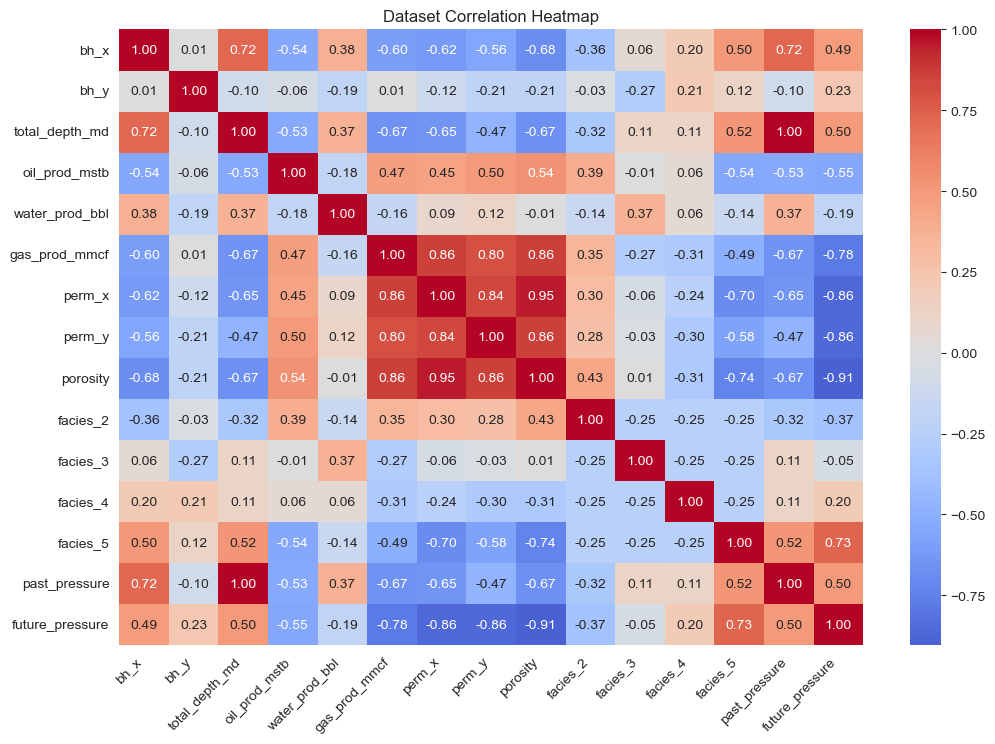

In [122]:
# Heatmap to display correlations
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', center=0)
plt.title('Dataset Correlation Heatmap')
plt.xticks(rotation=45, ha='right')
plt.show()

### Model Creation

In [123]:
# Define target (Y) and features (X)
X = df.drop(columns=['oil_prod_mstb'])  
y = df['oil_prod_mstb']

# Train test data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [124]:
# Linear regression
linear = LinearRegression()
linear.fit(X_train, y_train)

# Predictions
y_pred_ols = linear.predict(X_test)

# Evaluation
print("Linear Regression R²:", r2_score(y_test, y_pred_ols))
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_ols)))

# Coefficients ordinary least squares (OLS)
coeffs_ols = pd.Series(linear.coef_, index=X.columns).sort_values()
print("\nTop coefficients (OLS):\n", coeffs_ols.tail(10))

Linear Regression R²: 0.31274248812207295
Linear Regression RMSE: 32.109355271134895

Top coefficients (OLS):
 future_pressure   -1.010413e-01
bh_x              -1.677472e-03
bh_y              -1.882123e-04
gas_prod_mmcf      1.984990e-03
facies_2           1.600848e+01
facies_3           1.661414e+01
facies_5           2.045593e+01
facies_4           2.731511e+01
perm_y             8.887311e+02
past_pressure      1.469837e+07
dtype: float64


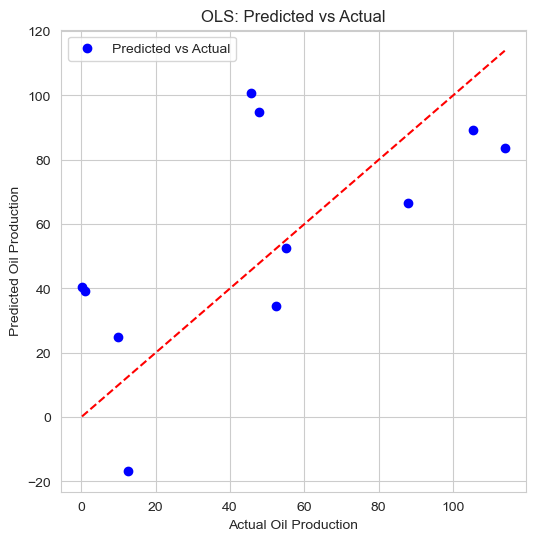

In [125]:
# Visualize predicted vs actual
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_ols, color='blue', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  
plt.xlabel('Actual Oil Production')
plt.ylabel('Predicted Oil Production')
plt.title('OLS: Predicted vs Actual')
plt.legend()
plt.show()

# Linear model not capturing relationship well - dots far off


In [126]:
# # Ridge with cross-validation to pick best alpha
# alphas = np.logspace(-3, 3, 13)  # 0.001 to 1000

# ridge_cv = Pipeline([
#     ('scaler', StandardScaler()),  # scale features so Ridge is fair
#     ('ridge', RidgeCV(alphas=alphas))
# ])

# ridge_cv.fit(X_train, y_train)
# y_pred_ridge = ridge_cv.predict(X_test)

# print("Ridge Best alpha:", ridge_cv.named_steps['ridge'].alpha_)
# print("Ridge R²:", round(r2_score(y_test, y_pred_ridge), 4))
# print("Ridge RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred_ridge)), 4))

# plt.figure(figsize=(6,6))
# plt.scatter(y_test, y_pred_ridge, color='green', label='Ridge Predicted vs Actual')
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
# plt.xlabel('Actual Oil Production')
# plt.ylabel('Predicted Oil Production')
# plt.title('Ridge: Predicted vs Actual')
# plt.legend()
# plt.show()

# lasso_cv = Pipeline([
#     ('scaler', StandardScaler()),
#     ('lasso', LassoCV(cv=5, max_iter=5000))
# ])

# lasso_cv.fit(X_train, y_train)
# y_pred_lasso = lasso_cv.predict(X_test)

# print("Lasso Best alpha:", lasso_cv.named_steps['lasso'].alpha_)
# print("Lasso R²:", round(r2_score(y_test, y_pred_lasso), 4))
# print("Lasso RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred_lasso)), 4))

# # Which features Lasso kept
# coeffs_lasso = pd.Series(lasso_cv.named_steps['lasso'].coef_, index=X.columns)
# print("\nLasso coefficients:\n", coeffs_lasso[coeffs_lasso != 0])




# coef_df = pd.DataFrame({
#     'OLS': ols.coef_,
#     'Ridge': ridge_cv.named_steps['ridge'].coef_,
#     'Lasso': lasso_cv.named_steps['lasso'].coef_
# }, index=X.columns).sort_values(by='OLS')

# coef_df.plot(kind='barh', figsize=(8,10))
# plt.title('Coefficients: OLS vs Ridge vs Lasso')
# plt.xlabel('Coefficient value')
# plt.tight_layout()
# plt.show()




In [127]:
# # porosity vs oil production (prediction feature vs target variable)
# x = df['porosity']
# y = df['oil_prod_mstb']

# slope, intercept, r_value, p_value, std_err = st.linregress(x, y)

# print("Slope:", slope)
# print("Intercept:", intercept)
# print("R²:", r_value**2)
# print("p-value:", p_value)
# print("Std Err:", std_err)

In [128]:
# plt.scatter(x, y)
# plt.plot(x, slope * x + intercept, color="red", label="Line of Best Fit")
# plt.xlabel("Porosity")
# plt.ylabel("Oil Production (MSTB)")
# plt.title("Linear Regression (porosity vs oil production)")
# plt.legend()
# plt.show()


c:\Users\shake\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Model R²: 0.936 | RMSE: 42.219


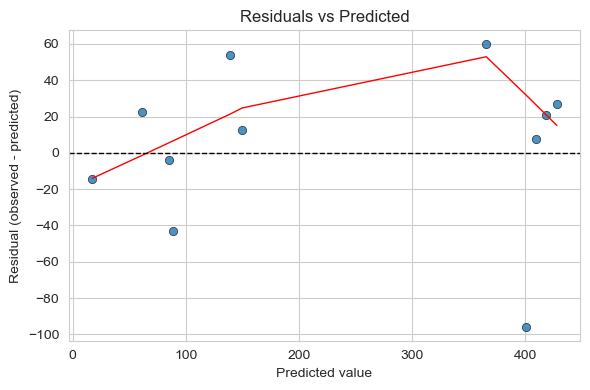

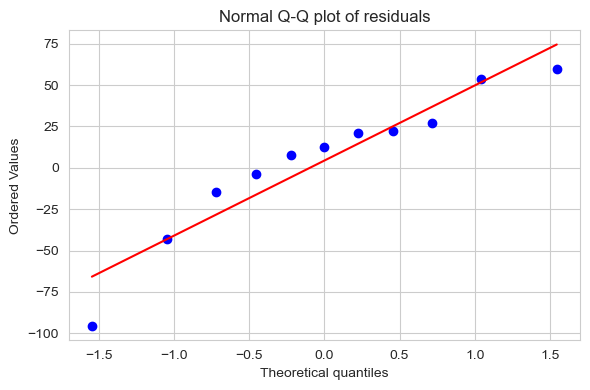

In [129]:
#Compute residuals
# Drop target column only
target = 'gas_prod_mmcf'
X = df.drop(columns=[target])
y = df[target]

#Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Train Random Forest
model = RandomForestRegressor(
    n_estimators=300, 
    max_depth=None, 
    random_state=42
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
residuals = y_test.values - y_pred
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f"Model R²: {r2:.3f} | RMSE: {rmse:.3f}")

#3) Plot diagnostics
sns.set_style("whitegrid")

#Residuals vs Predicted with LOWESS smoothing
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred, y=residuals, edgecolor="k", alpha=0.8)
sns.regplot(x=y_pred, y=residuals, lowess=True, scatter=False, line_kws={"color":"red", "lw":1})
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.xlabel("Predicted value")
plt.ylabel("Residual (observed - predicted)")
plt.title("Residuals vs Predicted")
plt.tight_layout()
plt.show()

#Normal Q-Q plot (probability plot)
plt.figure(figsize=(6,4))
st.probplot(residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q plot of residuals")
plt.tight_layout()
plt.show()

c:\Users\shake\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Model R²: 0.618 | RMSE: 21.617


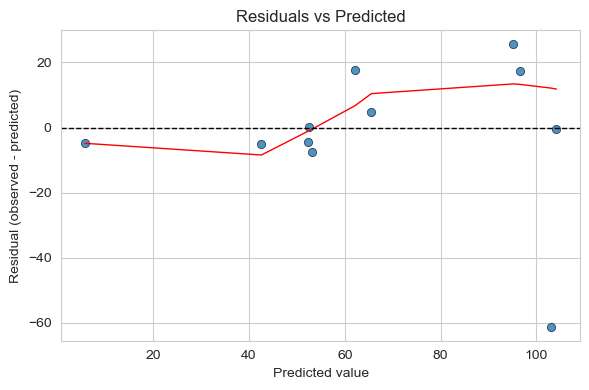

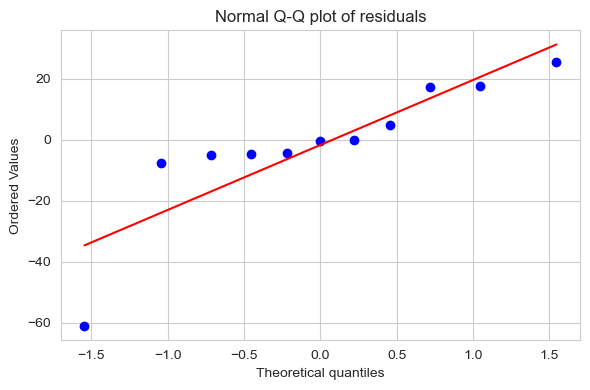

In [130]:
#Compute residuals
# Drop target column only
target = 'oil_prod_mstb'
X = df.drop(columns=[target])
y = df[target]

#Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Train Random Forest
model = RandomForestRegressor(
    n_estimators=300, 
    max_depth=None, 
    random_state=42
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
residuals = y_test.values - y_pred
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f"Model R²: {r2:.3f} | RMSE: {rmse:.3f}")

#3) Plot diagnostics
sns.set_style("whitegrid")

#Residuals vs Predicted with LOWESS smoothing
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred, y=residuals, edgecolor="k", alpha=0.8)
sns.regplot(x=y_pred, y=residuals, lowess=True, scatter=False, line_kws={"color":"red", "lw":1})
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.xlabel("Predicted value")
plt.ylabel("Residual (observed - predicted)")
plt.title("Residuals vs Predicted")
plt.tight_layout()
plt.show()

#Normal Q-Q plot (probability plot)
plt.figure(figsize=(6,4))
st.probplot(residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q plot of residuals")
plt.tight_layout()
plt.show()


R²: 0.6177147185580755
RMSE: 21.616974299473785


c:\Users\shake\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


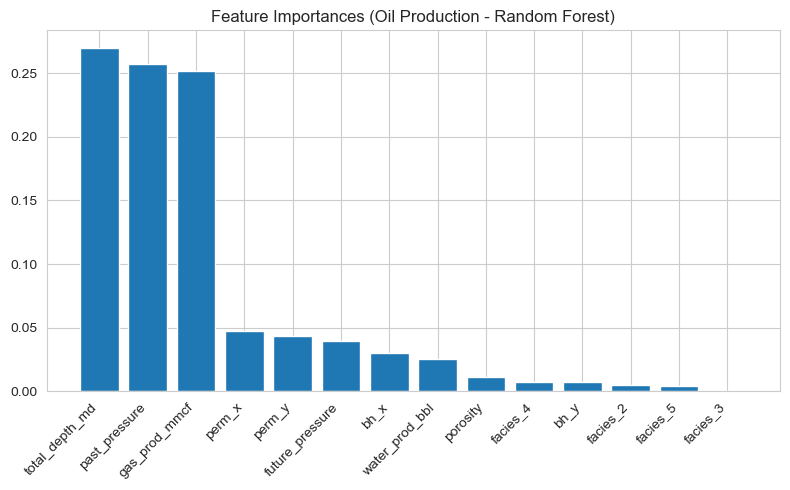

R²: 0.9362283090026723
RMSE: 42.21931835855995


c:\Users\shake\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


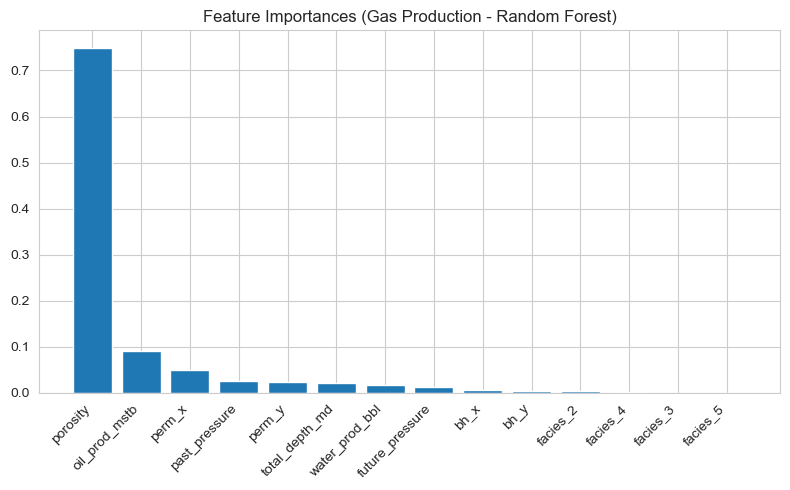

In [131]:
target = "oil_prod_mstb" 

# Drop target column only
X = df.drop(columns=[target])
y = df[target]

#Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Train Random Forest
model = RandomForestRegressor(
    n_estimators=300, 
    max_depth=None, 
    random_state=42
)
model.fit(X_train, y_train)

#Predictions
y_pred = model.predict(X_test)

#Evaluation
print("R²:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))

#Feature Importance Plot
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,5))
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=45, ha="right")
plt.title("Feature Importances (Oil Production - Random Forest)")
plt.tight_layout()
plt.show()
# For gas production (mmcf)
target = "gas_prod_mmcf" 

# Drop target column only
X = df.drop(columns=[target])
y = df[target]

#Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Train Random Forest
model = RandomForestRegressor(
    n_estimators=300, 
    max_depth=None, 
    random_state=42
)
model.fit(X_train, y_train)

#Predictions
y_pred = model.predict(X_test)

#Evaluation
print("R²:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))

#Feature Importance Plot
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,5))
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=45, ha="right")
plt.title("Feature Importances (Gas Production - Random Forest)")
plt.tight_layout()
plt.show()

In [132]:
#OLS Summary for oil production
X = df[["porosity", "gas_prod_mmcf", "bh_y", "bh_x", "facies_2", "facies_3", "facies_4", "facies_5", "past_pressure", "water_prod_bbl"]]
y = df["oil_prod_mstb"]
X[["facies_2", "facies_3", "facies_4", "facies_5"]] = \
    X[["facies_2", "facies_3", "facies_4", "facies_5"]].astype(int)
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          oil_prod_mstb   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                     5.208
Date:                Mon, 13 Oct 2025   Prob (F-statistic):           5.19e-05
Time:                        18:23:38   Log-Likelihood:                -256.00
No. Observations:                  55   AIC:                             534.0
Df Residuals:                      44   BIC:                             556.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -39.2359    877.375     -0.

C:\Users\shake\AppData\Local\Temp\ipykernel_37792\2143881299.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[["facies_2", "facies_3", "facies_4", "facies_5"]] = \


In [133]:
print(model.pvalues)

const             0.964533
porosity          0.123977
gas_prod_mmcf     0.078183
bh_y              0.732921
bh_x              0.276667
facies_2          0.001895
facies_3          0.007557
facies_4          0.006261
facies_5          0.051354
past_pressure     0.902864
water_prod_bbl    0.190871
dtype: float64


In [134]:
#OLS Summary for oil production after removing high p-value features
X = df[["porosity", "gas_prod_mmcf", "facies_2", "facies_3", "facies_4", "facies_5", "water_prod_bbl"]]
y = df["oil_prod_mstb"]
X[["facies_2", "facies_3", "facies_4", "facies_5"]] = \
    X[["facies_2", "facies_3", "facies_4", "facies_5"]].astype(int)
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          oil_prod_mstb   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     7.485
Date:                Mon, 13 Oct 2025   Prob (F-statistic):           4.84e-06
Time:                        18:23:38   Log-Likelihood:                -256.88
No. Observations:                  55   AIC:                             529.8
Df Residuals:                      47   BIC:                             545.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -193.4932     89.025     -2.

C:\Users\shake\AppData\Local\Temp\ipykernel_37792\3662757295.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[["facies_2", "facies_3", "facies_4", "facies_5"]] = \


In [135]:
print(model.pvalues)

const             0.034817
porosity          0.025653
gas_prod_mmcf     0.072253
facies_2          0.000976
facies_3          0.002925
facies_4          0.002708
facies_5          0.029728
water_prod_bbl    0.017212
dtype: float64


In [136]:
X = df[["porosity", "oil_prod_mstb", "bh_y", "bh_x", "facies_2", "facies_3", "facies_4", "facies_5", "past_pressure", "water_prod_bbl"]]
y = df["gas_prod_mmcf"]
X[["facies_2", "facies_3", "facies_4", "facies_5"]] = \
    X[["facies_2", "facies_3", "facies_4", "facies_5"]].astype(int)
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          gas_prod_mmcf   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     34.54
Date:                Mon, 13 Oct 2025   Prob (F-statistic):           1.39e-17
Time:                        18:23:38   Log-Likelihood:                -293.00
No. Observations:                  55   AIC:                             608.0
Df Residuals:                      44   BIC:                             630.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1845.8185   1696.477      1.

C:\Users\shake\AppData\Local\Temp\ipykernel_37792\447661456.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[["facies_2", "facies_3", "facies_4", "facies_5"]] = \


In [137]:
print(model.pvalues)

const             0.282506
porosity          0.115474
oil_prod_mstb     0.078183
bh_y              0.062242
bh_x              0.255042
facies_2          0.003512
facies_3          0.002420
facies_4          0.035971
facies_5          0.207628
past_pressure     0.259347
water_prod_bbl    0.850125
dtype: float64


In [138]:
X = df[["porosity", "oil_prod_mstb", "bh_y", "bh_x", "facies_2", "facies_3", "facies_4"]]
y = df["gas_prod_mmcf"]
X[["facies_2", "facies_3", "facies_4"]] = \
    X[["facies_2", "facies_3", "facies_4"]].astype(int)
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          gas_prod_mmcf   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     49.00
Date:                Mon, 13 Oct 2025   Prob (F-statistic):           1.79e-19
Time:                        18:23:38   Log-Likelihood:                -294.77
No. Observations:                  55   AIC:                             605.5
Df Residuals:                      47   BIC:                             621.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -291.9584     60.019     -4.864

C:\Users\shake\AppData\Local\Temp\ipykernel_37792\2081002452.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[["facies_2", "facies_3", "facies_4"]] = \


In [139]:
print(model.pvalues)

const            1.328494e-05
porosity         6.428387e-15
oil_prod_mstb    8.572070e-02
bh_y             9.367896e-03
bh_x             4.378714e-01
facies_2         3.899326e-03
facies_3         3.290122e-07
facies_4         1.156148e-03
dtype: float64


Summary Statistics:



                        mean          50%          std           min  \
bh_x             7589.476364  7668.400000  4156.444078  1.012810e+03   
bh_y             7116.958000  5933.160000  3940.735399  7.244300e+02   
total_depth_md   8539.674545  8519.000000    83.861334  8.429100e+03   
oil_prod_mstb      61.929930    52.504300    37.913359  4.644580e-02   
water_prod_bbl      5.165370     0.000300    18.109040  8.560000e-08   
gas_prod_mmcf     188.803059   162.333925   149.560601  8.435022e-02   
perm_x              0.027481     0.027701     0.018500  6.680000e-05   
perm_y              0.022876     0.016377     0.018372  6.680000e-05   
porosity            0.135532     0.135415     0.039870  6.307772e-02   
past_pressure    3487.981393  3481.121691    27.824736  3.451293e+03   
future_pressure  2790.943485  2746.230378   259.330503  2.422838e+03   

                          max  
bh_x             14034.610000  
bh_y             13746.230000  
total_depth_md    8775.700000  
oil_pro

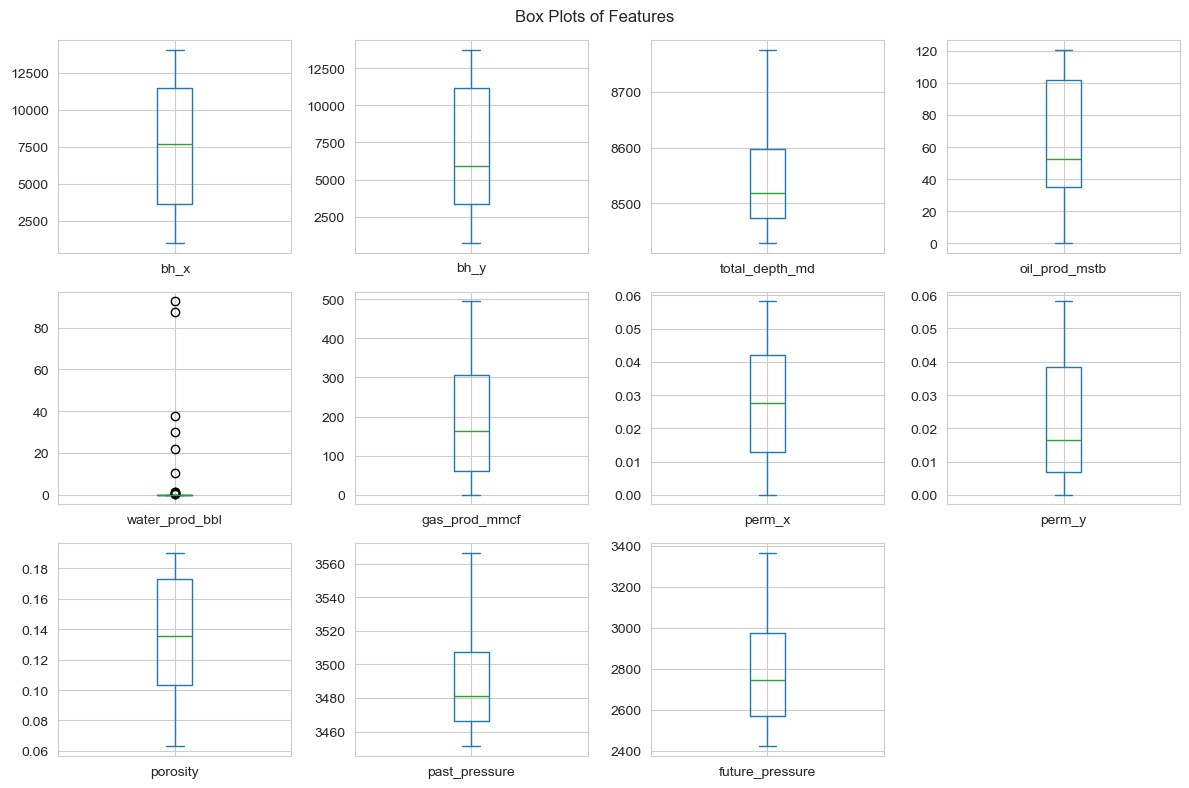

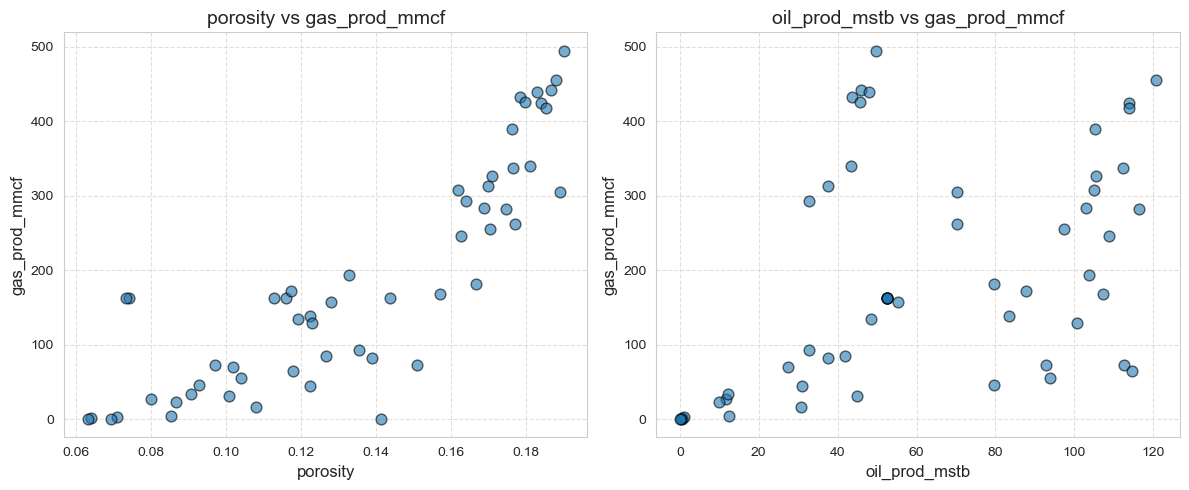

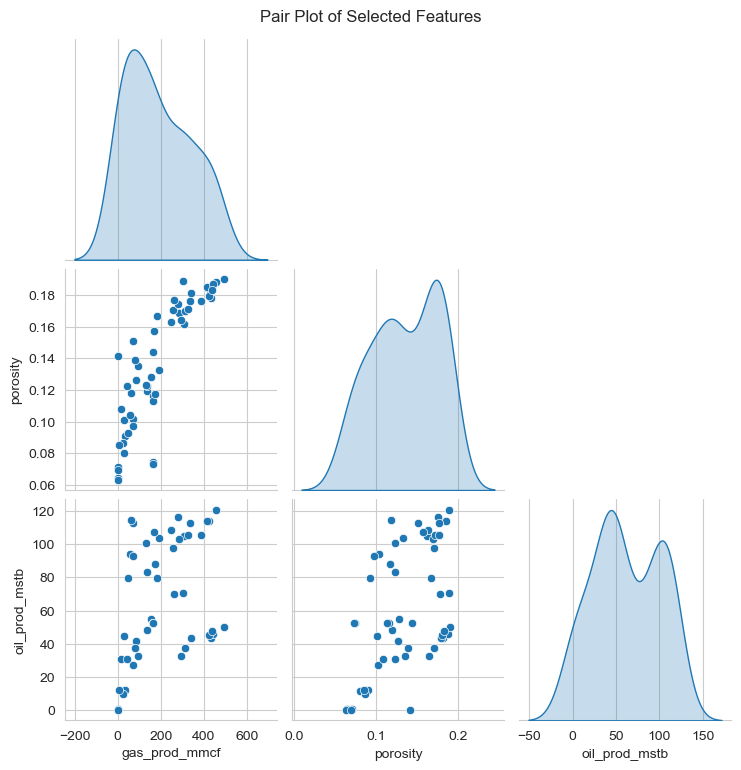

In [140]:
#Summary statistics
print("Summary Statistics:\n")
print(df.describe().T[["mean", "50%", "std", "min", "max"]])

# Box plots for each numeric feature
df.plot(kind="box", subplots=True, layout=(3, 4), figsize=(12, 8), sharex=False, sharey=False)
plt.suptitle("Box Plots of Features")
plt.tight_layout()
plt.show()

# Target and features
target = "gas_prod_mmcf"
numeric_features = ["porosity", "oil_prod_mstb"]

# Scatter plots
plt.figure(figsize=(12, 5))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(1, len(numeric_features), i)
    plt.scatter(df[col], df[target], alpha=0.6, edgecolor="k", s=60)
    plt.xlabel(col, fontsize=12)
    plt.ylabel(target, fontsize=12)
    plt.title(f"{col} vs {target}", fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


#Pair plot for selected features
selected_features = [target, "porosity", "oil_prod_mstb"] 
sns.pairplot(df[selected_features], diag_kind="kde", corner=True)
plt.suptitle("Pair Plot of Selected Features", y=1.02)
plt.show()

C:\Users\shake\AppData\Local\Temp\ipykernel_37792\3478120990.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="facies_2", y="oil_prod_mstb", data=df, palette="Set2")


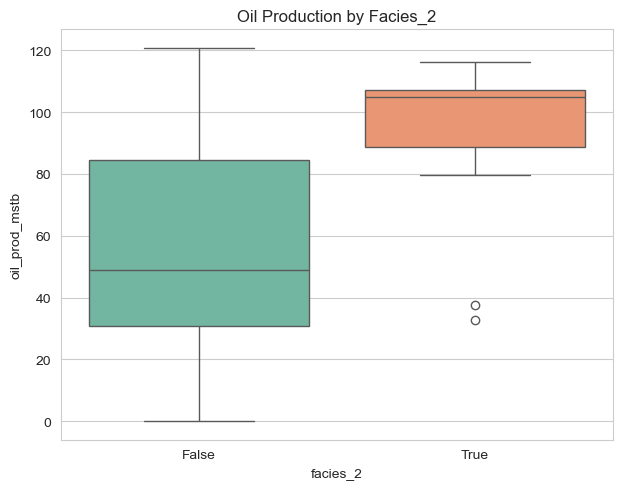

In [141]:
#Box plots for categorical feature facies_2 vs oil production 
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x="facies_2", y="oil_prod_mstb", data=df, palette="Set2")
plt.title("Oil Production by Facies_2")

plt.tight_layout()
plt.show()

C:\Users\shake\AppData\Local\Temp\ipykernel_37792\1826015869.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="facies_3", y="oil_prod_mstb", data=df, palette="Set2")


Text(0.5, 1.0, 'Oil Production by Facies_3')

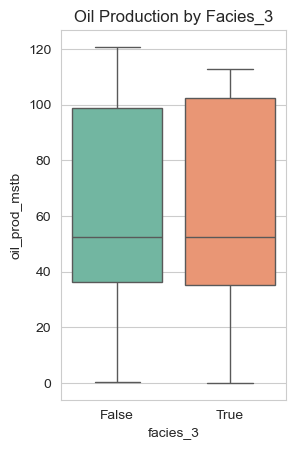

In [142]:
# Box plots for categorical feature facies_3 vs oil production
plt.subplot(1, 2, 1)
sns.boxplot(x="facies_3", y="oil_prod_mstb", data=df, palette="Set2")
plt.title("Oil Production by Facies_3")

C:\Users\shake\AppData\Local\Temp\ipykernel_37792\1462916465.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="facies_4", y="oil_prod_mstb", data=df, palette="Set2")


Text(0.5, 1.0, 'Oil Production by Facies_4')

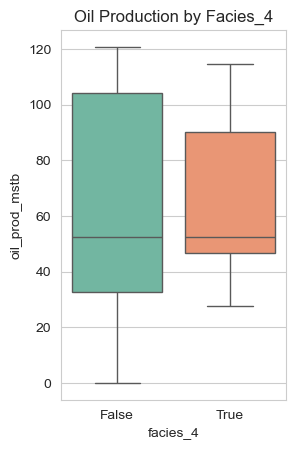

In [143]:
# Box plots for categorical feature facies_4 vs oil production
plt.subplot(1, 2, 1)
sns.boxplot(x="facies_4", y="oil_prod_mstb", data=df, palette="Set2")
plt.title("Oil Production by Facies_4")

C:\Users\shake\AppData\Local\Temp\ipykernel_37792\1168155789.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="facies_5", y="oil_prod_mstb", data=df, palette="Set2")


Text(0.5, 1.0, 'Oil Production by Facies_5')

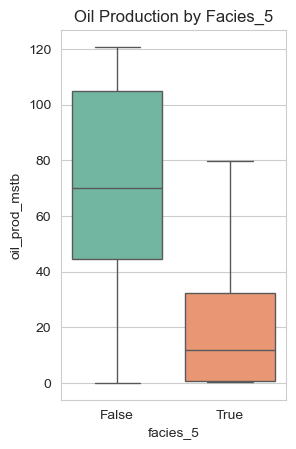

In [144]:
#Box plots for categorical feature facies_5 vs oil production
plt.subplot(1, 2, 1)
sns.boxplot(x="facies_5", y="oil_prod_mstb", data=df, palette="Set2")
plt.title("Oil Production by Facies_5")

C:\Users\shake\AppData\Local\Temp\ipykernel_37792\2005950654.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="facies_2", y="gas_prod_mmcf", data=df, palette="Set2")


Text(0.5, 1.0, 'Gas Production by Facies_2')

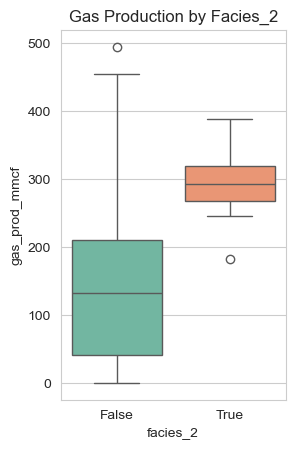

In [145]:
# Box plots for categorical feature facies_2 vs gas production
plt.subplot(1, 2, 1)
sns.boxplot(x="facies_2", y="gas_prod_mmcf", data=df, palette="Set2")
plt.title("Gas Production by Facies_2")

C:\Users\shake\AppData\Local\Temp\ipykernel_37792\1330232061.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="facies_3", y="gas_prod_mmcf", data=df, palette="Set2")


Text(0.5, 1.0, 'Gas Production by Facies_3')

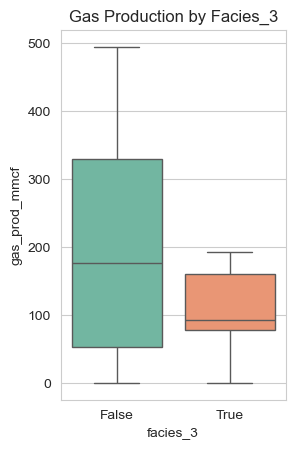

In [146]:
# Box plots for categorical feature facies_3 vs gas production
plt.subplot(1, 2, 1)
sns.boxplot(x="facies_3", y="gas_prod_mmcf", data=df, palette="Set2")
plt.title("Gas Production by Facies_3")

C:\Users\shake\AppData\Local\Temp\ipykernel_37792\3330340322.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="facies_4", y="gas_prod_mmcf", data=df, palette="Set2")


Text(0.5, 1.0, 'Gas Production by Facies_4')

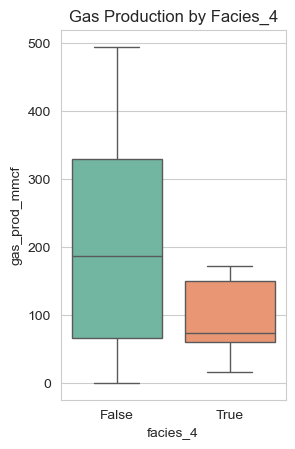

In [147]:
# Box plots for categorical feature facies_4 vs gas production
plt.subplot(1, 2, 1)
sns.boxplot(x="facies_4", y="gas_prod_mmcf", data=df, palette="Set2")
plt.title("Gas Production by Facies_4")

C:\Users\shake\AppData\Local\Temp\ipykernel_37792\2379069976.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="facies_5", y="gas_prod_mmcf", data=df, palette="Set2")


Text(0.5, 1.0, 'Gas Production by Facies_5')

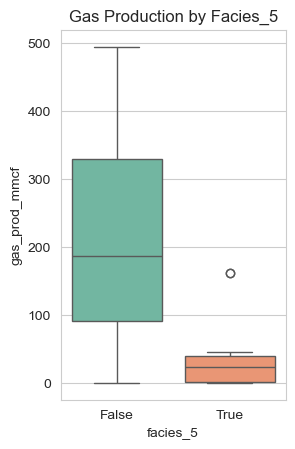

In [148]:
# Box plots for categorical feature facies_5 vs gas production
plt.subplot(1, 2, 1)
sns.boxplot(x="facies_5", y="gas_prod_mmcf", data=df, palette="Set2")
plt.title("Gas Production by Facies_5")

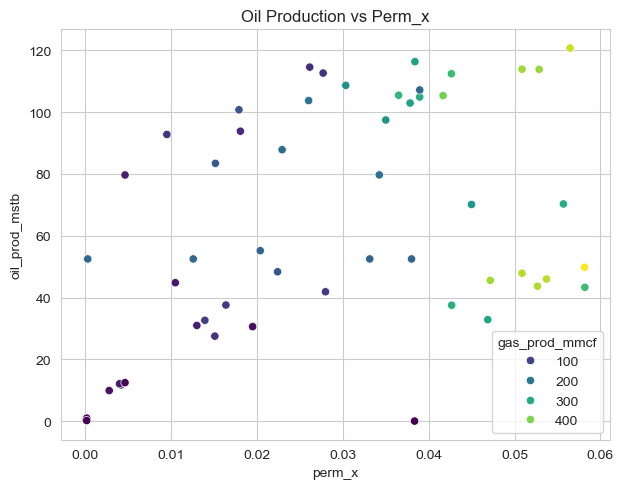

In [149]:
# Scatter plots for permeability vs oil and gas production colored by facies
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x="perm_x", y="oil_prod_mstb", data=df, hue="gas_prod_mmcf", palette="viridis")
plt.title("Oil Production vs Perm_x")

plt.tight_layout()
plt.show()

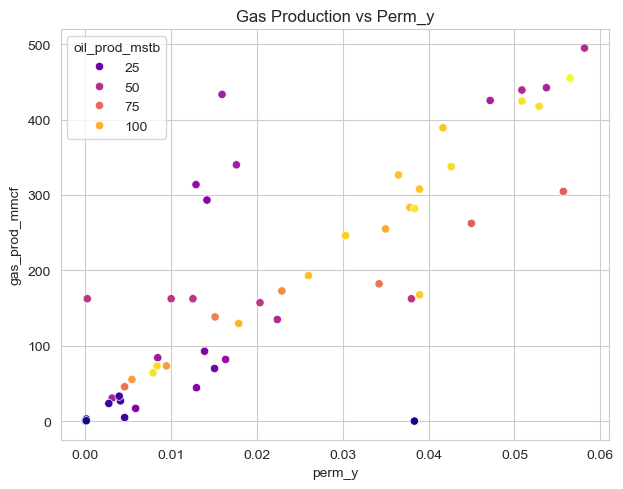

In [150]:
# Scatter plots for permeability vs oil and gas production colored by facies
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
sns.scatterplot(x="perm_y", y="gas_prod_mmcf", data=df, hue="oil_prod_mstb", palette="plasma")
plt.title("Gas Production vs Perm_y")
plt.tight_layout()
plt.show()

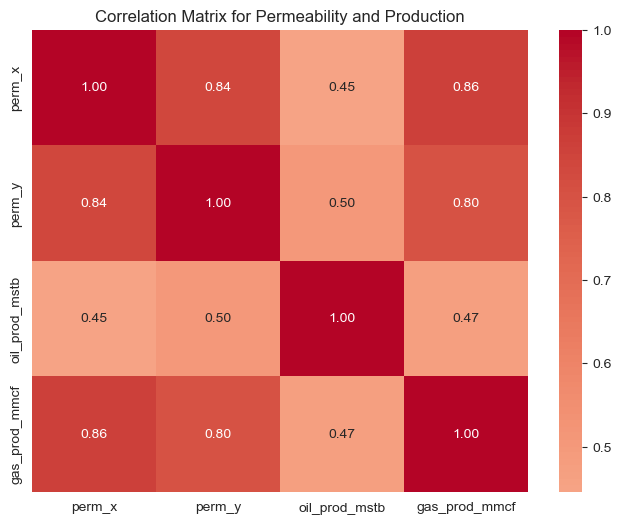

In [151]:
# Correlation for permeability compared to oil and gas production
corr_matrix = df[['perm_x', 'perm_y', 'oil_prod_mstb', 'gas_prod_mmcf']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', center=0)
plt.title('Correlation Matrix for Permeability and Production')
plt.show()

In [153]:
# Define predictors (permeability and facies dummies)
# copy to avoid SettingWithCopyWarning and ensure numeric dtypes for statsmodels
X = df[["perm_x", "perm_y", "facies_2", "facies_3", "facies_4", "facies_5"]].copy()

# Ensure facies dummies are numeric (0/1) and all predictors are float
facies_cols = ["facies_2", "facies_3", "facies_4", "facies_5"]
X[facies_cols] = X[facies_cols].astype(int)
X = X.astype(float)

#Oil Production Model
y_oil = df["oil_prod_mstb"]

X_oil = sm.add_constant(X)
model_oil = sm.OLS(y_oil, X_oil).fit()
print("\n=== Oil Production Regression Results ===")
print(model_oil.summary())

#Gas Production Model
y_gas = df["gas_prod_mmcf"]

X_gas = sm.add_constant(X)
model_gas = sm.OLS(y_gas, X_gas).fit()
print("\n=== Gas Production Regression Results ===")
print(model_gas.summary())


=== Oil Production Regression Results ===
                            OLS Regression Results                            
Dep. Variable:          oil_prod_mstb   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     5.981
Date:                Mon, 13 Oct 2025   Prob (F-statistic):           0.000100
Time:                        18:24:27   Log-Likelihood:                -262.13
No. Observations:                  55   AIC:                             538.3
Df Residuals:                      48   BIC:                             552.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const    

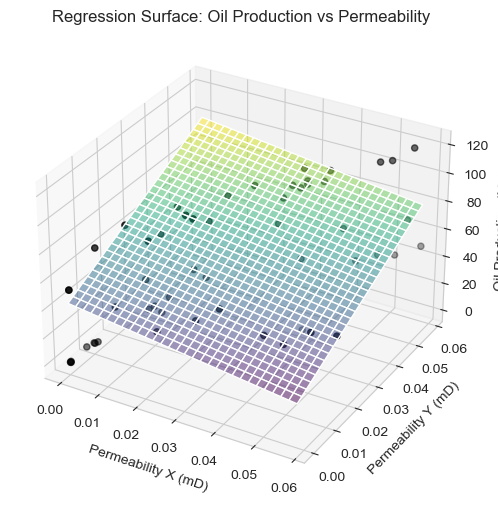

In [154]:
# Create grid for perm_x and perm_y
perm_x_range = np.linspace(df["perm_x"].min(), df["perm_x"].max(), 30)
perm_y_range = np.linspace(df["perm_y"].min(), df["perm_y"].max(), 30)
X_grid, Y_grid = np.meshgrid(perm_x_range, perm_y_range)

# Predict oil production on grid (using only permeability, ignoring facies)
Z_pred = (model_oil.params["const"] +
           model_oil.params["perm_x"] * X_grid +
           model_oil.params["perm_y"] * Y_grid)

# 3D surface plot
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X_grid, Y_grid, Z_pred, alpha=0.5, cmap="viridis")
ax.scatter(df["perm_x"], df["perm_y"], df["oil_prod_mstb"], color="black", s=20)
ax.set_xlabel("Permeability X (mD)")
ax.set_ylabel("Permeability Y (mD)")
ax.set_zlabel("Oil Production (MSTB)")
plt.title("Regression Surface: Oil Production vs Permeability")
plt.show()


In [170]:

#Basic checks and preprocessing
print("Columns:", df.columns.tolist())
print(df.describe(include="all").T)

# Standardize facies detection (handles dummy columns facies_2..5)
facies_cols = [c for c in df.columns if c.lower().startswith("facies")]
if facies_cols:
    # If they are dummies, create single 'Facies' label (e.g. 'facies_2')
    df["Facies"] = df[facies_cols].idxmax(axis=1)
else:
    # If single facies column exists
    for name in ["facies", "facies_type", "Facies"]:
        if name in df.columns:
            df["Facies"] = df[name].astype(str)
            break

Columns: ['bh_x', 'bh_y', 'total_depth_md', 'oil_prod_mstb', 'water_prod_bbl', 'gas_prod_mmcf', 'perm_x', 'perm_y', 'porosity', 'facies_2', 'facies_3', 'facies_4', 'facies_5', 'past_pressure', 'future_pressure', 'is_top_total', 'is_top_gas', 'perm_geom_mean', 'perm_arith_mean', 'log_perm_x', 'log_perm_y', 'log_perm_geom_mean', 'log_perm_arith_mean']
                    count unique    top freq         mean          std  \
bh_x                 55.0    NaN    NaN  NaN  7589.476364  4156.444078   
bh_y                 55.0    NaN    NaN  NaN     7116.958  3940.735399   
total_depth_md       55.0    NaN    NaN  NaN  8539.674545    83.861334   
oil_prod_mstb        55.0    NaN    NaN  NaN     61.92993    37.913359   
water_prod_bbl       55.0    NaN    NaN  NaN      5.16537     18.10904   
gas_prod_mmcf        55.0    NaN    NaN  NaN   188.803059   149.560601   
perm_x               55.0    NaN    NaN  NaN     0.027481       0.0185   
perm_y               55.0    NaN    NaN  NaN     0.02287

In [178]:
# Identify production columns (oil and gas)
por_col = None
for c in ["porosity", "phi", "porosity_frac", "por"]:
    if c in df.columns:
        por_col = c
        break

In [164]:
# Known numeric columns
num_cols = []
for c in ["perm_x", "perm_y", "perm_x_mD", "perm_y_mD", "perm_x_mD", "perm_y_mD"]:
    if c in df.columns: num_cols.append(c)
# Accept provided column names
for c in ["perm_x", "perm_y", "oil_prod_mstb", "gas_prod_mmcf"]:
    if c in df.columns and c not in num_cols:
        num_cols.append(c)

In [165]:
# Fill names if present
perm_x = "perm_x" if "perm_x" in df.columns else None
perm_y = "perm_y" if "perm_y" in df.columns else None
oil_col = "oil_prod_mstb" if "oil_prod_mstb" in df.columns else None
gas_col = "gas_prod_mmcf" if "gas_prod_mmcf" in df.columns else None

In [168]:
# Spatial coordinates detection (for maps)
x_col = 'bh_x' if 'bh_x' in df.columns else None
y_col = 'bh_y' if 'bh_y' in df.columns else None

# If defaults not present, search for common coordinate column names
if x_col is None or y_col is None:
    found = False
    for x_candidate in ["x", "lon", "longitude", "easting", "east", "map_x", "bh_x"]:
        for y_candidate in ["y", "lat", "latitude", "northing", "north", "map_y", "bh_y"]:
            if x_candidate in df.columns and y_candidate in df.columns:
                x_col, y_col = x_candidate, y_candidate
                found = True
                break
        if found:
            break
# Final check
if x_col is None or y_col is None:
    raise KeyError("Could not detect spatial coordinate columns in df. Checked for common names including 'bh_x' and 'bh_y'.")

In [169]:
# Create new features based on permeability if both perm_x and perm_y exist
if perm_x and perm_y:
    df["perm_geom_mean"] = np.sqrt(np.abs(df[perm_x] * df[perm_y]))  # geometric mean (robust to orientation)
    df["perm_arith_mean"] = (df[perm_x] + df[perm_y]) / 2
    # add logs (handle zeros/negatives)
    for c in [perm_x, perm_y, "perm_geom_mean", "perm_arith_mean"]:
        if c in df.columns:
            df[f"log_{c}"] = np.log1p(np.clip(df[c], a_min=0, a_max=None))

In [171]:
# Standardize production columns
if oil_col and gas_col:
    # you can analyze oil and gas separately and combined
    df["prod_total_std"] = (df[oil_col].fillna(0).pipe(lambda s: (s - s.mean()) / (s.std() + 1e-9))
                           + df[gas_col].fillna(0).pipe(lambda s: (s - s.mean()) / (s.std() + 1e-9)))
    # Top performers
    df["is_top_oil"] = df[oil_col] >= df[oil_col].quantile(0.9) if oil_col else False
    df["is_top_gas"] = df[gas_col] >= df[gas_col].quantile(0.9) if gas_col else False
    df["is_top_total"] = df["prod_total_std"] >= df["prod_total_std"].quantile(0.9)

In [172]:
# Summary statistics function
def summarize_by_group(col, target_flag):
    grp = df.groupby(col)[[oil_col, gas_col]].agg(['count', 'mean', 'median', 'std'])
    print(f"\nSummary by {col}:")
    display(grp)

if "Facies" in df.columns:
    print("\nCounts per facies:")
    print(df["Facies"].value_counts(dropna=False))
    # Average production per facies
    facies_prod = df.groupby("Facies")[[oil_col, gas_col, "perm_arith_mean"]].median().sort_values(by=oil_col, ascending=False)
    print("\nMedian production & perm by facies:")
    display(facies_prod)


Counts per facies:
Facies
facies_2    22
facies_3    11
facies_4    11
facies_5    11
Name: count, dtype: int64

Median production & perm by facies:


,oil_prod_mstb,gas_prod_mmcf,perm_arith_mean
Facies,,,
facies_2,88.58375,331.977262,0.040311
facies_3,52.50430,92.684539,0.018227
facies_4,52.50430,73.282796,0.015088
facies_5,11.74200,23.415476,0.000284


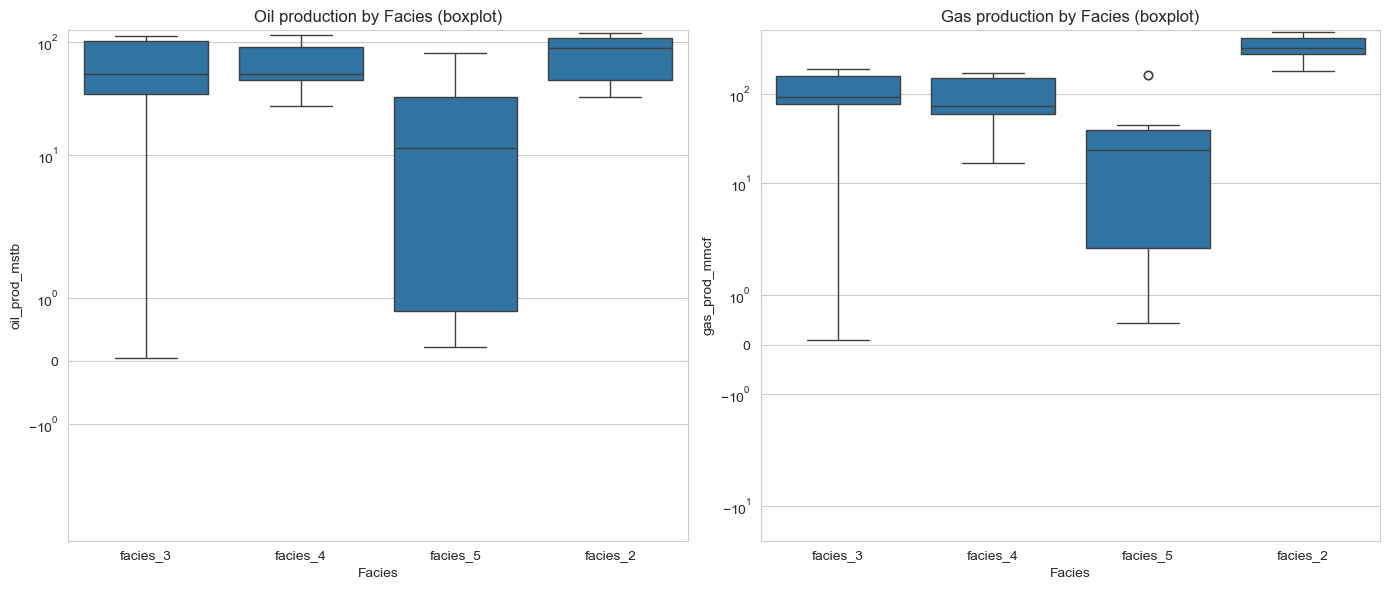

In [ ]:
# Boxplots & violin plots for oil production by facies
plt.figure(figsize=(14,6))
if "Facies" in df.columns and oil_col:
    plt.subplot(1,2,1)
    sns.boxplot(x="Facies", y=oil_col, data=df)
    plt.title("Oil production by Facies (boxplot)")
    plt.yscale("symlog")  # helps with wide ranges


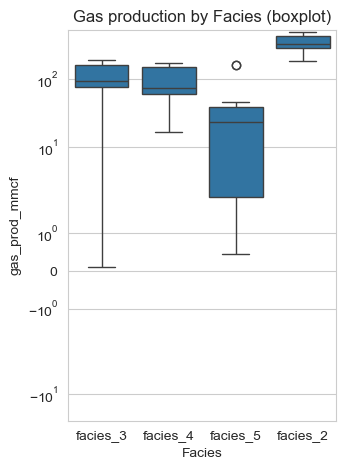

In [175]:
# Boxplots & violin plots for gas production by facies
if "Facies" in df.columns and gas_col:
    plt.subplot(1,2,2)
    sns.boxplot(x="Facies", y=gas_col, data=df)
    plt.title("Gas production by Facies (boxplot)")
    plt.yscale("symlog")
plt.tight_layout()
plt.show()

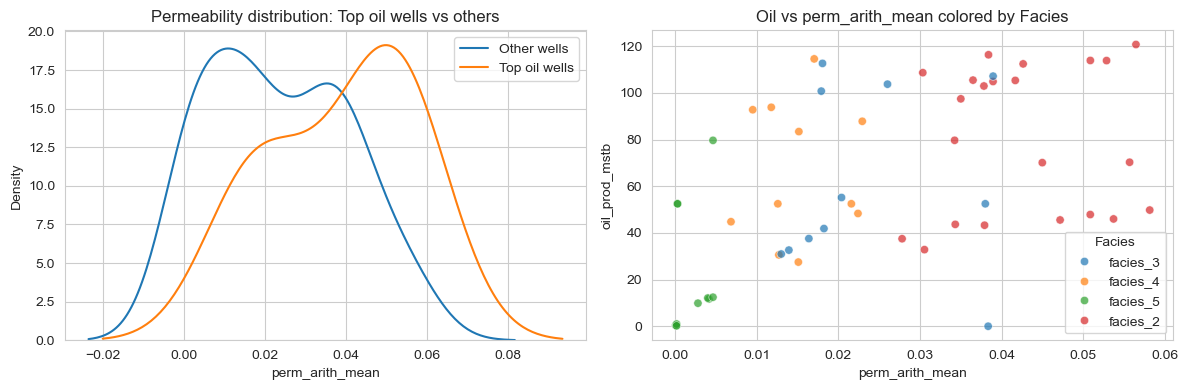

In [176]:
# Compare perm distributions for top wells vs others
if perm_x and perm_y and oil_col:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.kdeplot(df.loc[~df["is_top_oil"], "perm_arith_mean"].dropna(), label="Other wells")
    sns.kdeplot(df.loc[df["is_top_oil"], "perm_arith_mean"].dropna(), label="Top oil wells")
    plt.xlabel("perm_arith_mean")
    plt.legend()
    plt.title("Permeability distribution: Top oil wells vs others")
    plt.subplot(1,2,2)
    sns.scatterplot(x="perm_arith_mean", y=oil_col, hue="Facies", data=df, alpha=0.7)
    plt.title("Oil vs perm_arith_mean colored by Facies")
    plt.tight_layout()
    plt.show()

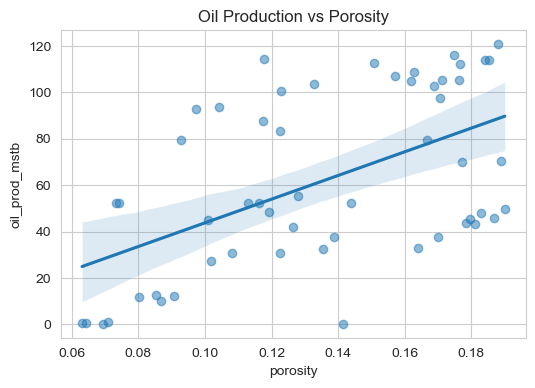

In [179]:
# Porosity vs production if present
if por_col and oil_col:
    plt.figure(figsize=(6,4))
    sns.regplot(x=por_col, y=oil_col, data=df, scatter_kws={"alpha":0.5})
    plt.title("Oil Production vs Porosity")
    plt.show()

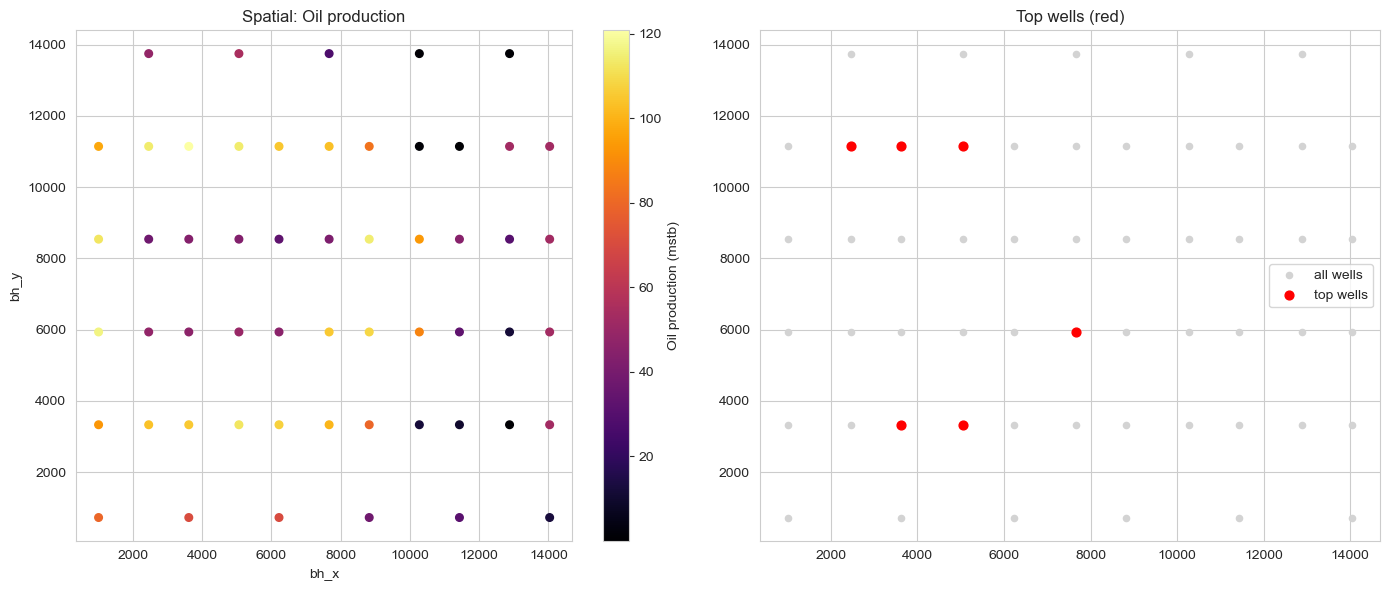

In [181]:
# Spatial plots if coordinates present
if x_col and y_col:
    plt.figure(figsize=(14,6))
    plt.subplot(1,2,1)
    sc = plt.scatter(df[x_col], df[y_col], c=df[oil_col].fillna(0), s=30, cmap="inferno")
    plt.colorbar(sc, label="Oil production (mstb)")
    plt.title("Spatial: Oil production")
    plt.xlabel(x_col); plt.ylabel(y_col)
    if "is_top_total" in df.columns:
        plt.subplot(1,2,2)
        # plot wells, highlight top-decile
        plt.scatter(df[x_col], df[y_col], c="lightgrey", s=20, label="all wells")
        plt.scatter(df.loc[df["is_top_total"], x_col], df.loc[df["is_top_total"], y_col], c="red", s=40, label="top wells")
        plt.legend()
        plt.title("Top wells (red)")
    plt.tight_layout()
    plt.show()

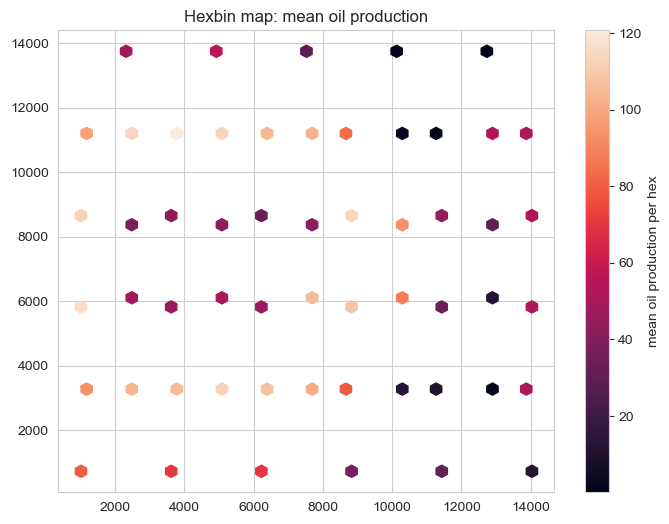

In [182]:
# Hexbin (density weighted by production)
plt.figure(figsize=(8,6))
plt.hexbin(df[x_col], df[y_col], C=df[oil_col].fillna(0), reduce_C_function=np.mean, gridsize=40)
plt.colorbar(label="mean oil production per hex")
plt.title("Hexbin map: mean oil production")
plt.show()

In [183]:

# Check if gradients differ by fluid type: fit simple linear models per fluid
if "fluid_type" in df.columns:
    for fluid in df["fluid_type"].unique():
        sub = df.loc[df["fluid_type"]==fluid]
        if len(sub) > 10:
            r = np.corrcoef(sub[drawdown_col].fillna(0), sub[oil_col].fillna(0))[0,1]
            print(f"Fluid {fluid} correlation drawdown vs oil: {r:.2f}")

In [184]:
# Build X matrix: perm_x, perm_y, porosity if available, facies dummies
model_features = []
for v in [perm_x, perm_y, "perm_arith_mean", "perm_geom_mean", por_col]:
    if v in df.columns: model_features.append(v)

In [185]:
# Ensure unique
model_features = list(dict.fromkeys(model_features))
print("Model features:", model_features)

# Prepare dataset for modelling; remove rows with missing target/features
if oil_col:
    model_df = df.dropna(subset=model_features + [oil_col]).copy()
    X = model_df[model_features].values
    y = model_df[oil_col].values
    # scale features
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    # Add polynomial interactions (simple: include pairwise interactions)
    poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    Xp = poly.fit_transform(Xs)

    # Ridge regression with cross-validation for robust coefficients
    rr = RidgeCV(alphas=np.logspace(-3, 3, 7), cv=5)
    rr.fit(Xp, y)
    print("RidgeCV best alpha:", rr.alpha_)
    print("Ridge coefficients (first 20):", rr.coef_[:20])

Model features: ['perm_x', 'perm_y', 'perm_arith_mean', 'perm_geom_mean', 'porosity']
RidgeCV best alpha: 100.0
Ridge coefficients (first 20): [ 1.81429431  3.45438386  2.74185373  2.97935284  3.26197739 -0.17787853
 -1.96759413 -1.44707547 -2.691873    0.06381417  0.13589675  0.28314099
 -0.68596173 -1.26028392 -0.80764796]


In [187]:
# Random forest for importance & non-linear relationships
rf = RandomForestRegressor(n_estimators=300, random_state=42, max_depth=6)
rf.fit(Xs, y)
importances = pd.Series(rf.feature_importances_, index=model_features).sort_values(ascending=False)
print("\nRandom forest feature importances:")
print(importances.head(15))



Random forest feature importances:
perm_y             0.274014
perm_x             0.242745
porosity           0.213032
perm_arith_mean    0.145250
perm_geom_mean     0.124959
dtype: float64


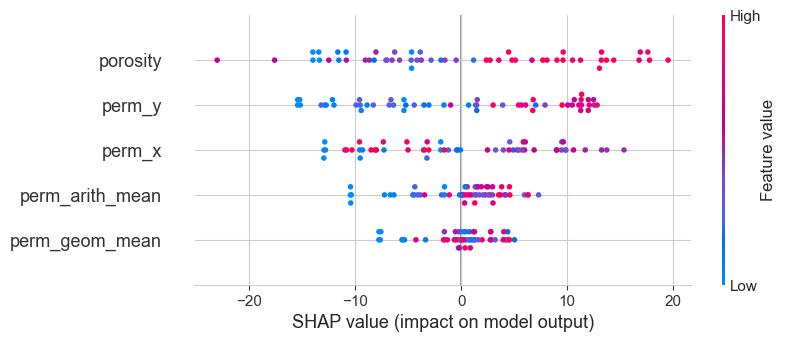

RandomForest CV R^2 mean ± std: -0.17447375208124977 0.6756442094866587


In [188]:
# Predictions and evaluation
try:
    explainer = shap.Explainer(rf, Xs, feature_names=model_features)
    shap_values = explainer(Xs[:200])  # sample for speed
    shap.plots.beeswarm(shap_values, max_display=15)
except Exception as e:
    print("SHAP plotting skipped or errored:", e)

# Cross-validated R^2
cv = KFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(rf, Xs, y, cv=cv, scoring="r2")
print("RandomForest CV R^2 mean ± std:", scores.mean(), scores.std())

In [189]:
# Repeat for gas production 
if gas_col:
    model_df_g = df.dropna(subset=model_features + [gas_col]).copy()
    Xg = model_df_g[model_features].values
    yg = model_df_g[gas_col].values
    Xgs = scaler.transform(Xg) if 'scaler' in locals() else StandardScaler().fit_transform(Xg)
    rf_g = RandomForestRegressor(n_estimators=300, random_state=42, max_depth=6)
    rf_g.fit(Xgs, yg)
    print("Gas model feature importances:")
    print(pd.Series(rf_g.feature_importances_, index=model_features).sort_values(ascending=False).head(10))

Gas model feature importances:
porosity           0.791501
perm_x             0.081069
perm_y             0.049073
perm_geom_mean     0.047856
perm_arith_mean    0.030501
dtype: float64


In [191]:
# Use rf predictions if available; else simple linear combination
if 'rf' in locals() and oil_col:
    df.loc[model_df.index, "pred_oil"] = rf.predict(Xs)
else:
    if "perm_arith_mean" in df.columns:
        df["pred_oil"] = df["perm_arith_mean"].fillna(0) * 0.3 + df[por_col].fillna(0)*0.3 if por_col else df["perm_arith_mean"].fillna(0)

# Create facies score: median production per facies normalized
if "Facies" in df.columns and oil_col:
    facies_median = df.groupby("Facies")[oil_col].median()
    df["facies_score"] = df["Facies"].map(facies_median).fillna(0)
else:
    df["facies_score"] = 0


In [193]:
# Compose final score
components = []
if "pred_oil" in df.columns: 
    df["score_pred"] = (df["pred_oil"] - df["pred_oil"].mean()) / (df["pred_oil"].std() + 1e-9); components.append("score_pred")
if "perm_arith_mean" in df.columns:
    df["score_perm"] = (df["perm_arith_mean"] - df["perm_arith_mean"].mean()) / (df["perm_arith_mean"].std() + 1e-9); components.append("score_perm")
if por_col and por_col in df.columns:
    df["score_por"] = (df[por_col] - df[por_col].mean()) / (df[por_col].std() + 1e-9); components.append("score_por")
df["score_facies"] = (df["facies_score"] - df["facies_score"].mean())/(df["facies_score"].std()+1e-9); components.append("score_facies")

In [ ]:
# Weighted average
weights = {c: 1/len(components) for c in components}
df["sweetspot_score"] = sum(df[c]*weights[c] for c in components)

# Rank and list top N recommendations
topN = 10
top_candidates = df.sort_values("sweetspot_score", ascending=False).head(topN)
print(f"\nTop {topN} candidate wells / grid points by sweetspot_score:")
display(top_candidates[[x_col, y_col, "Facies", "sweetspot_score", oil_col, gas_col]].head(topN))


Top 10 candidate wells / grid points by sweetspot_score:


,bh_x,bh_y,Facies,sweetspot_score,oil_prod_mstb,gas_prod_mmcf
12,3617.17,11141.88,facies_2,1.323086,120.7430,455.032070
13,2459.67,11141.88,facies_2,1.222504,113.8510,417.537157
11,5064.04,11141.88,facies_2,1.179464,113.9040,424.497427
49,3617.17,724.43,facies_2,1.170936,70.3040,304.670678
30,5064.04,5933.16,facies_2,1.115010,49.8170,494.772320
48,5064.04,3328.80,facies_2,1.111516,112.4416,337.495037
47,3617.17,3328.80,facies_2,1.102220,105.3550,389.044408
29,3617.17,5933.16,facies_2,1.056782,46.0120,442.197254
35,1012.81,5933.16,facies_2,1.021170,116.3390,281.897025
33,7668.40,5933.16,facies_2,0.968449,105.4785,326.459487


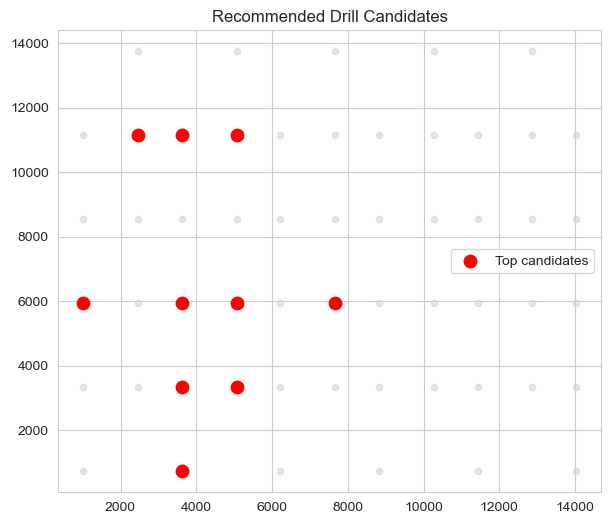

In [195]:
# Map top candidates if spatial present
if x_col and y_col:
    plt.figure(figsize=(7,6))
    plt.scatter(df[x_col], df[y_col], c="lightgrey", s=20, alpha=0.6)
    plt.scatter(top_candidates[x_col], top_candidates[y_col], c="red", s=80, label="Top candidates")
    plt.legend()
    plt.title("Recommended Drill Candidates")
    plt.show()

In [197]:
# Interactive 3D sweet spot map
fig = px.scatter_3d(
    df,
    x="perm_x",
    y="perm_y",
    z="gas_prod_mmcf",
    color="sweetspot_score",
    size="oil_prod_mstb",
    hover_data=["Facies", "perm_x", "perm_y", "oil_prod_mstb", "gas_prod_mmcf", "sweetspot_score"],
    title="3D Sweet Spot Map: Facies, Permeability, and Production",
    color_continuous_scale="YlGnBu"
)

fig.update_traces(marker=dict(opacity=0.85, line=dict(width=0)))
fig.update_layout(scene=dict(
    xaxis_title='Permeability X (mD)',
    yaxis_title='Permeability Y (mD)',
    zaxis_title='Gas Production (MMCF)',
), coloraxis_colorbar=dict(title="Sweet Spot Score"))

fig.show()

In [199]:
# Normalize selected variables
scaler = MinMaxScaler()
features = ["oil_prod_mstb", "gas_prod_mmcf", "perm_x", "perm_y"]
df_scaled = pd.DataFrame(scaler.fit_transform(df[features]), columns=features)

# Create a composite sweet spot score (adjust weights as needed)
df["sweetspot_score"] = (
    0.4 * df_scaled["oil_prod_mstb"] +
    0.3 * df_scaled["gas_prod_mmcf"] +
    0.2 * df_scaled["perm_x"] +
    0.1 * df_scaled["perm_y"]
)
facies_cols = ["facies_2", "facies_3", "facies_4", "facies_5"]
df["Facies"] = df[facies_cols].idxmax(axis=1)

In [200]:
# 3D scatter plot
fig = px.scatter_3d(
    df,
    x="bh_x",
    y="bh_y",
    z="gas_prod_mmcf",
    color="sweetspot_score",
    size="oil_prod_mstb",
    hover_data=["Facies", "perm_x", "perm_y", "oil_prod_mstb", "gas_prod_mmcf", "sweetspot_score"],
    title="3D Spatial Map of Sweet Spots (Wells by Bottom-Hole Coordinates)",
    color_continuous_scale="YlOrRd"
)

fig.update_traces(marker=dict(opacity=0.85, line=dict(width=0)))
fig.update_layout(scene=dict(
    xaxis_title="BH_X (Easting)",
    yaxis_title="BH_Y (Northing)",
    zaxis_title="Gas Production (MMCF)"
), coloraxis_colorbar=dict(title="Sweet Spot Score"))

fig.show()

In [201]:
# Highlight top 10 wells
top_wells = df.nlargest(10, "sweetspot_score")

fig.add_trace(
    px.scatter_3d(
        top_wells,
        x="bh_x",
        y="bh_y",
        z="gas_prod_mmcf",
        size="oil_prod_mstb",
        text="Facies"
    ).data[0]
)

fig.update_traces(marker=dict(color="red", size=10, symbol="diamond"), selector=dict(mode="markers"))
fig.show()